In [12]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler

spark = SparkSession.builder \
    .appName("FlightDelayPrediction") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

df = spark.read.csv("flight_data.csv", header=True, inferSchema=True)
df.printSchema()


df = df.dropna(subset=["ARR_DELAY", "DEP_DELAY"])

df = df.fillna({
    'DELAY_DUE_CARRIER': 0, 
    'DELAY_DUE_WEATHER': 0, 
    'DELAY_DUE_NAS': 0, 
    'DELAY_DUE_SECURITY': 0, 
    'DELAY_DUE_LATE_AIRCRAFT': 0
})

# editing format of the date and creating a severe delay for flights delayed over one hour
df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))
df = df.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= 60, 1).otherwise(0))

# dropping columns that we don't need
columns_to_drop = ['CANCELLATION_CODE', 'AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER']
df = df.drop(*columns_to_drop)

# encoding the categorical variables and adding index/onehot after them in the columns
categorical_cols = ["AIRLINE", "ORIGIN", "DEST"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}Index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}Index", outputCol=f"{col}OneHot") for col in categorical_cols]

# using vector assembler on numerical data
numeric_cols = ["DEP_DELAY", "TAXI_OUT", "TAXI_IN", "ARR_DELAY", "DISTANCE",
                "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS",
                "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"]

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# making the final assembler
final_assembler = VectorAssembler(
    inputCols=["AIRLINEOneHot", "ORIGINOneHot", "DESTOneHot", "scaled_features"],
    outputCol="final_features"
)

# pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, final_assembler])
processed_df = pipeline.fit(df).transform(df)

processed_df.select("final_features", "SEVERE_DELAY").show(5)


25/03/23 19:22:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
                                                                                

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

[Stage 189:==============>                                          (2 + 6) / 8]

+--------------------+------------+
|      final_features|SEVERE_DELAY|
+--------------------+------------+
|(785,[4,40,414,77...|           0|
|(785,[1,30,404,77...|           0|
|(785,[4,20,409,77...|           0|
|(785,[1,30,410,77...|           0|
|(785,[11,26,397,7...|           0|
+--------------------+------------+
only showing top 5 rows



In [23]:
from pyspark.sql.types import IntegerType, DoubleType, FloatType
import pandas as pd
# Get a list of columns with numeric types
numericColumns = [col for col, dtype in df.dtypes if isinstance(df.schema[col].dataType, (IntegerType, DoubleType, FloatType))]

print(numericColumns)
# Get the basic statistics of the DataFrame for the numeric columns
df_stats = df.select([F.round(F.col(c), 2).alias(c) for c in numericColumns]).describe()

# Convert the result to a Pandas DataFrame
df_stats_pd = df_stats.toPandas()

# Round the numeric values (except for the 'summary' row)
df_stats_pd.iloc[1:, 1:] = df_stats_pd.iloc[1:, 1:].apply(pd.to_numeric, errors='coerce').round(2)

# Set the 'summary' features as the index
df_stats_pd.set_index('summary', inplace=True)

print(df_stats_pd)

['CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT', 'SEVERE_DELAY', 'DEP_HOUR', 'DEP_DAY_OF_WEEK', 'DEP_MONTH', 'IS_WEEKEND']


[Stage 346:==========================================>              (6 + 2) / 8]

        CRS_DEP_TIME DEP_TIME DEP_DELAY TAXI_OUT WHEELS_OFF WHEELS_ON  \
summary                                                                 
count        2913802  2913802   2913802  2913802    2913802   2913802   
mean         1326.08  1329.62     10.05    16.64    1352.26   1462.35   
stddev        485.58   499.36     49.05     9.18     500.93    526.97   
min              1.0      1.0     -90.0      1.0        1.0       1.0   
max           2359.0   2400.0    2966.0    184.0     2400.0    2400.0   

         TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY  ... DELAY_DUE_CARRIER  \
summary                                           ...                     
count    2913802      2913802  2913802   2913802  ...           2913802   
mean        7.67      1489.82  1466.38      4.26  ...              4.54   
stddev      6.25       511.04   531.55     51.17  ...             32.18   
min          1.0          1.0      1.0     -96.0  ...               0.0   
max        249.0       2400.0   2400.0

# Visualization

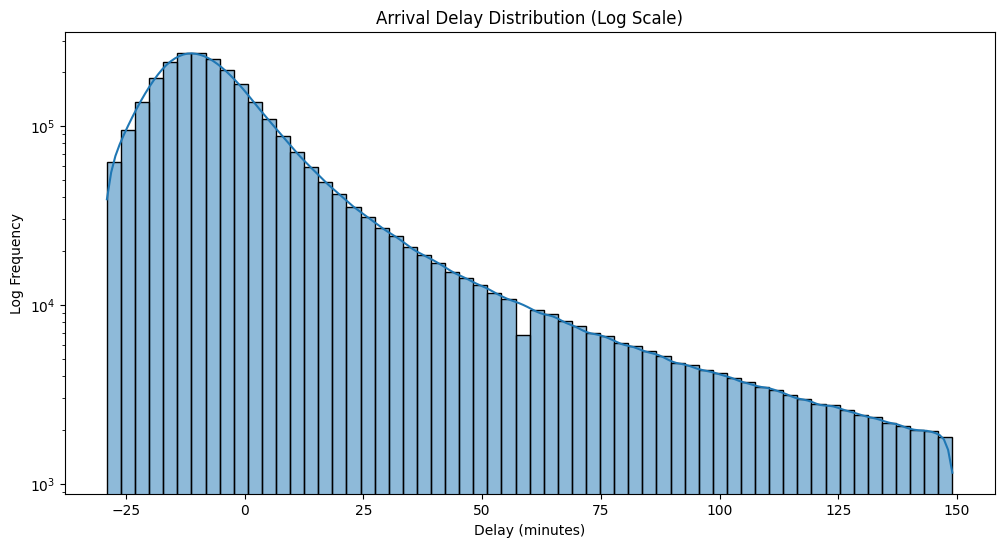

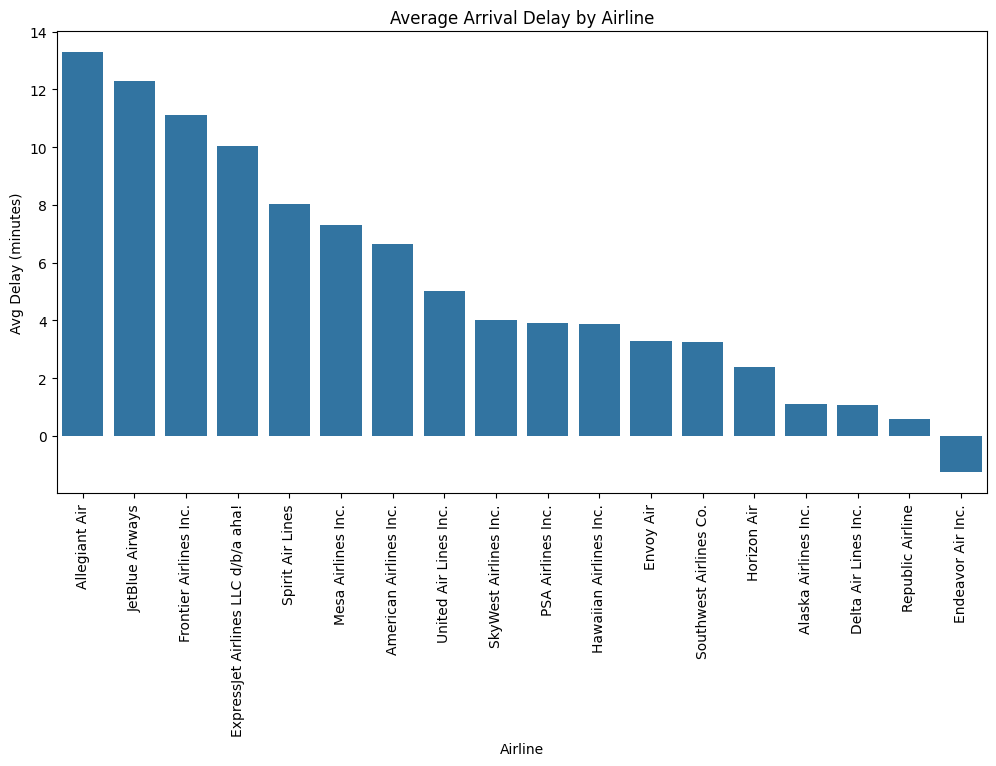

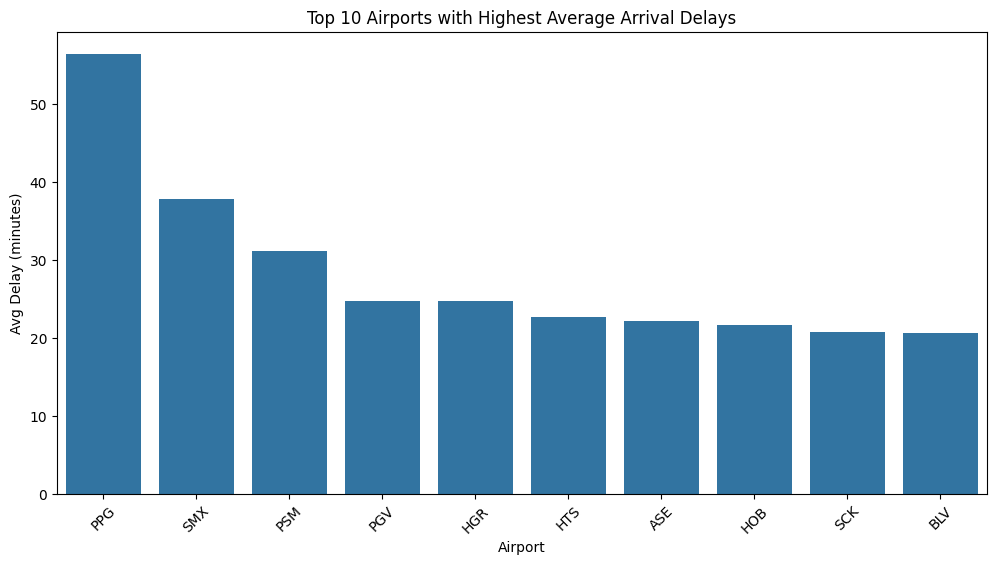

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pd = df.select("ARR_DELAY", "AIRLINE", "ORIGIN").toPandas()

# Arrival Delay Distribution
pd_df_filtered = df_pd[(df_pd["ARR_DELAY"] > -30) & (df_pd["ARR_DELAY"] < 150)]

plt.figure(figsize=(12, 6))
sns.histplot(pd_df_filtered["ARR_DELAY"].dropna(), bins=60, kde=True)
plt.yscale("log")
plt.title("Arrival Delay Distribution (Log Scale)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Log Frequency")
plt.show()

# Average Arrival Delay by Airline
airline_delays = df_pd.groupby("AIRLINE")["ARR_DELAY"].mean().reset_index().sort_values("ARR_DELAY", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="AIRLINE", y="ARR_DELAY", data=airline_delays)
plt.xticks(rotation=90)
plt.title("Average Arrival Delay by Airline")
plt.xlabel("Airline")
plt.ylabel("Avg Delay (minutes)")
plt.show()

# Top 10 Airports with Highest Delays
airport_delays = df_pd.groupby("ORIGIN")["ARR_DELAY"].mean().reset_index().sort_values("ARR_DELAY", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x="ORIGIN", y="ARR_DELAY", data=airport_delays)
plt.title("Top 10 Airports with Highest Average Arrival Delays")
plt.xlabel("Airport")
plt.ylabel("Avg Delay (minutes)")
plt.xticks(rotation=45)
plt.show()


# More Feature Engineering

In [15]:
# extracting time-based features from scheduled departure time (CRS_DEP_TIME) column
df = df.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("integer"))
df = df.withColumn("DEP_DAY_OF_WEEK", F.dayofweek(F.col("FL_DATE")))
df = df.withColumn("DEP_MONTH", F.month(F.col("FL_DATE")))

# weekend flights most likely have higher likelihood of being delayed so we'll flag these
df = df.withColumn("IS_WEEKEND", F.when(F.col("DEP_DAY_OF_WEEK").isin([1, 7]), 1).otherwise(0))


# updating numeric columns
numeric_cols_extended = numeric_cols + [
    "DEP_HOUR", "DEP_DAY_OF_WEEK", "DEP_MONTH", "IS_WEEKEND"
]

assembler_extended = VectorAssembler(
    inputCols=numeric_cols_extended,
    outputCol="extended_features"
)

scaler_extended = MinMaxScaler(inputCol="extended_features", outputCol="scaled_extended_features")

final_assembler_extended = VectorAssembler(
    inputCols=["AIRLINEOneHot", "ORIGINOneHot", "DESTOneHot", "scaled_extended_features"],
    outputCol="final_features_extended"
)


pipeline_extended = Pipeline(stages=indexers + encoders + [assembler_extended, scaler_extended, final_assembler_extended])

final_df = pipeline_extended.fit(df).transform(df)

# this will act as the final df for now
final_df.select("final_features_extended", "SEVERE_DELAY").show(5)


+-----------------------+------------+
|final_features_extended|SEVERE_DELAY|
+-----------------------+------------+
|   (789,[4,40,414,77...|           0|
|   (789,[1,30,404,77...|           0|
|   (789,[4,20,409,77...|           0|
|   (789,[1,30,410,77...|           0|
|   (789,[11,26,397,7...|           0|
+-----------------------+------------+
only showing top 5 rows



# Initial Model Creation

In [16]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Select the final features and label
model_df = final_df.select("final_features_extended", "SEVERE_DELAY") \
                                .withColumnRenamed("final_features_extended", "features") \
                                .withColumnRenamed("SEVERE_DELAY", "label")

sample_df = model_df.sample(withReplacement=False, fraction=0.1, seed=101)

# Train/Test split
train_df, test_df = sample_df.randomSplit([0.7, 0.3], seed=101)

# RandomForest model training
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
rf_model = rf.fit(train_df)

# Predictions on test set
predictions = rf_model.transform(test_df)

# Evaluate accuracy
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy (AUC): {accuracy:.4f}")


25/03/23 19:32:47 WARN MemoryStore: Not enough space to cache rdd_678_4 in memory! (computed 31.3 MiB so far)
25/03/23 19:32:47 WARN BlockManager: Persisting block rdd_678_4 to disk instead.
25/03/23 19:32:47 WARN MemoryStore: Not enough space to cache rdd_678_3 in memory! (computed 31.3 MiB so far)
25/03/23 19:32:47 WARN BlockManager: Persisting block rdd_678_3 to disk instead.
25/03/23 19:32:47 WARN MemoryStore: Not enough space to cache rdd_678_5 in memory! (computed 47.1 MiB so far)
25/03/23 19:32:47 WARN BlockManager: Persisting block rdd_678_5 to disk instead.
25/03/23 19:32:47 WARN MemoryStore: Not enough space to cache rdd_678_1 in memory! (computed 19.1 MiB so far)
25/03/23 19:32:47 WARN BlockManager: Persisting block rdd_678_1 to disk instead.
25/03/23 19:32:47 WARN MemoryStore: Not enough space to cache rdd_678_6 in memory! (computed 31.3 MiB so far)
25/03/23 19:32:47 WARN BlockManager: Persisting block rdd_678_6 to disk instead.
25/03/23 19:32:48 WARN MemoryStore: Not enoug

Test Accuracy (AUC): 0.9994
